In [139]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
from datetime import datetime as dt

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Data

In [141]:
# 1. Dataset read
data_path = "datas/movielens_small/{}"

ratings_df = pd.read_csv(data_path.format("ratings.csv"), encoding='utf-8')
ratings_df.drop("timestamp", inplace=True, axis=1)

print("평점 데이터 shape : {}".format(ratings_df.shape))
ratings_df.head()

평점 데이터 shape : (100004, 3)


,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [142]:
movies_df = pd.read_csv(data_path.format("movies.csv"), encoding='utf-8')
movies_df.set_index("movieId", inplace=True)

print("영화 데이터 shape : {}".format(movies_df.shape))
movies_df.head()

영화 데이터 shape : (9125, 2)


,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [143]:
# 2. dummy genre setting
# - 영화별 장르 포함 정보를 가진 dummy data
dummy_genre_df = movies_df['genres'].str.get_dummies(sep="|")

print("* (영화 수, 장르 수)")
print("장르 포함 정보 데이터 shape : {}".format(dummy_genre_df.shape))
dummy_genre_df.head()

* (영화 수, 장르 수)
장르 포함 정보 데이터 shape : (9125, 20)


,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [144]:
# 3. year parsing
# - 영화별 년도 정보 추출

# 3-1. (4자리) 타입의 문자열 추출
years = movies_df['title'].str.extract("(\(\d\d\d\d\))")[0].values.astype("str")

# 3-2. 괄호 제거 (nan은 0으로 대치)
years = np.array([0 if y == 'nan' else int(y.replace("(","").replace(")","")) for y in years])

# 3-3. movie column 삽입
movies_df['year'] = years

# 3-4. 년도 정보가 없었던 데이터는 삭제
movies_df.drop(movies_df[movies_df['year'] == 0].index, axis=0, inplace=True)

# 3-5. 제목 칼럼 삭제
movies_df.drop("title", axis=1, inplace=True)

print("영화 데이터 shape : {}".format(movies_df.shape))
movies_df.head()

영화 데이터 shape : (9119, 2)


,genres,year
movieId,,
1,Adventure|Animation|Children|Comedy|Fantasy,1995
2,Adventure|Children|Fantasy,1995
3,Comedy|Romance,1995
4,Comedy|Drama|Romance,1995
5,Comedy,1995


In [145]:
# 4. year-level generate
bins = np.arange(1900, 2023, 20)
labels = [x for x in range(len(bins) - 1)]

# 4-1. 구간 나누기
movies_df['year_level'] = pd.cut(movies_df['year'], bins, right=False, labels=labels)

# 4-2. year 칼럼 삭제
movies_df.drop('year', axis=1, inplace=True)

print("영화 데이터 shape : {}".format(movies_df.shape))
movies_df.head()

영화 데이터 shape : (9119, 2)


,genres,year_level
movieId,,
1,Adventure|Animation|Children|Comedy|Fantasy,4
2,Adventure|Children|Fantasy,4
3,Comedy|Romance,4
4,Comedy|Drama|Romance,4
5,Comedy,4


In [8]:
# 5. threshold data
# - 평점의 갯수가 10개 이상인 영화 데이터 기록

# 5-1. threshold setting each movie
threshold = 10
over_threshold = ratings_df.groupby('movieId').size() >= threshold

# 5-2. rating in
# - 평점의 갯수가 10개 이상인 영화인가? 에 대한 기록
ratings_df['over_threshold'] = ratings_df['movieId'].map(lambda x: over_threshold[x])

# 5-3. filtering
ratings_df = ratings_df[ratings_df['over_threshold']]
ratings_df.drop('over_threshold', axis=1, inplace=True)

print("평점 데이터 shape : {}".format(ratings_df.shape))
ratings_df.head()

평점 데이터 shape : (81915, 3)


,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [9]:
# 6. 최종 학습 데이터 셋 생성
shuffled_df = ratings_df.sample(frac=1)

# rating num user matrix
# 몇 번째 평점의 어떤 유저의 정보인가 matrix
ru_mat = pd.get_dummies(shuffled_df['userId'], prefix="user")

# rating and movie matrix
# 몇 번째 평점의 어떤 영화의 정보인가 matrix
rm_mat = pd.get_dummies(shuffled_df['movieId'], prefix="movie")

# rating and genre matrix
# 몇 번째 평점의 어떤 장르의 정보인가 matrix
rg_mat = shuffled_df['movieId'].apply(lambda x: dummy_genre_df.loc[x])

# ratings and year_level
# 몇 번째 평점의 어떤 년도의 정보인가 vector
ry_vec = shuffled_df['movieId'].apply(lambda x: movies_df.loc[x]['year_level']).rename('year_level')

# concat
concat_df = pd.concat([ru_mat, rm_mat, rg_mat, ry_vec], axis=1)

# 정말 그냥 평점이라는 고유 데이터에
# 사용자 번호 행렬, 영화 번호 행렬, 장르 행렬, 년도 레벨 합친 데이터 이다.
print("최종 학습 데이터셋 shape : {}".format(concat_df.shape))
concat_df.head()

최종 학습 데이터셋 shape : (81915, 2937)


,user_1,user_2,user_3,user_4,user_5,user_6,user_7,user_8,user_9,user_10,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year_level
19015,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,4
40362,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,4
74827,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,5
95292,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,5
78510,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,4


In [177]:
ru_mat.head()

,user_1,user_2,user_3,user_4,user_5,user_6,user_7,user_8,user_9,user_10,...,user_662,user_663,user_664,user_665,user_666,user_667,user_668,user_669,user_670,user_671
19015,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40362,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74827,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95292,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
78510,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [178]:
# 7. 훈련, 시험용 데이터 분리
from sklearn.model_selection import train_test_split

# target_df
## 지금까지와 다른 특징은 평점 데이터를 사용하지 않고
## 4점이 넘으면 보는 것, 넘지 않으면 안 보는 것으로 간주 -> 추천의 관점에서
target_df = ratings_df.loc[concat_df.index]['rating']
target_df = target_df.apply(lambda x: 1 if x >= 4 else 0)

X_train, X_test, y_train, y_test = train_test_split(concat_df, target_df, test_size=0.1)

print("훈련 데이터 shape : {}, 훈련 라벨 갯수 : {}".format(X_train.shape, y_train.size))
print("테스트 데이터 shape : {}, 테스트 라벨 갯수 : {}".format(X_test.shape, y_test.size))

훈련 데이터 shape : (73723, 2937), 훈련 라벨 갯수 : 73723
테스트 데이터 shape : (8192, 2937), 테스트 라벨 갯수 : 8192


In [179]:
target_df

19015    0
40362    0
74827    1
95292    1
78510    0
        ..
38873    1
55199    0
61855    0
82006    1
28705    0
Name: rating, Length: 81915, dtype: int64

# 2. Factorization Machine

## 1. FM Model Process

In [180]:
# 1. Setting Value 
num_factor = 8

# n = item count
# p = latent factor size
n, p = X_train.shape

In [181]:
# 2. tensor variable ref.Factorization Machine Model Operation (1)

# 2-1. Global Bias
w_0 = tf.Variable([0.0], name="Global Bias")

# 2-2. i 번째 개별 **특성**에 대한 가중치
w = tf.Variable(tf.zeros(shape=[p]), name="Weights")

# 2-3. v_i, v_factor 는 f개의 latent factor로 표현된 2-way interaction을 계산하는 내적을 의미
v = tf.Variable(tf.random.normal(shape=(p, num_factor)), name="Latent Factor")

trainable_variables = [w_0, w, v]
trainable_variables

[<tf.Variable 'Global Bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'Weights:0' shape=(2937,) dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'Latent Factor:0' shape=(2937, 8) dtype=float32, numpy=
 array([[ 0.08976322,  1.4009086 , -1.2873092 , ...,  0.8508741 ,
          0.8566282 , -1.127194  ],
        [-0.33199638, -0.12554619, -0.7974511 , ..., -0.3655508 ,
          0.7693333 , -1.5627393 ],
        [-0.68089664, -0.73689127, -1.5037374 , ...,  3.2013526 ,
          0.43591732, -1.5126821 ],
        ...,
        [ 0.38059172,  0.00975006,  0.57335615, ..., -0.04975786,
          0.26955578, -1.4743261 ],
        [ 0.852538  ,  0.03986191,  2.123211  , ...,  0.04355351,
         -0.04958765,  1.0583173 ],
        [-0.42111894, -0.67627245, -0.04366487, ...,  1.201627  ,
          0.8104332 , -0.17577437]], dtype=float32)>]

In [19]:
# 3. predictref.Factorization Machine Model Operation (1)

# 3-1. Setting
batch_size = 32
X_batch = tf.constant(X_train.to_numpy()[:batch_size], dtype=float)

In [172]:
# 3-2. predict function, keras.Model.call function
def predict():
    # 3-1. 시그마(W_i, x_i)
    degree_1 = tf.reduce_sum(tf.multiply(w, X_batch), axis=1)

    # 3-2. 오른쪽에 어려운 식 계산
    degree_2 = 0.5 * tf.reduce_sum(
            tf.math.pow(tf.matmul(X_batch, v), 2)
            - tf.matmul(tf.math.pow(X_batch, 2), tf.math.pow(v, 2)),
            1, keepdims=False
        )

    # 3-3. 나머지 계산 (Sigmoid)
    y_pred = tf.math.sigmoid(w_0 + degree_1, degree_2)
    
    return y_pred

print(predict().numpy())

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


In [186]:
trainable_variables

[<tf.Variable 'Global Bias:0' shape=(1,) dtype=float32, numpy=array([0.00999732], dtype=float32)>,
 <tf.Variable 'Weights:0' shape=(2937,) dtype=float32, numpy=
 array([ 0.000000e+00,  0.000000e+00,  0.000000e+00, ...,  1.999585e-02,
         0.000000e+00, -5.159527e-07], dtype=float32)>,
 <tf.Variable 'Latent Factor:0' shape=(2937, 8) dtype=float32, numpy=
 array([[ 0.08976322,  1.4009086 , -1.2873092 , ...,  0.8508741 ,
          0.8566282 , -1.127194  ],
        [-0.33199638, -0.12554619, -0.7974511 , ..., -0.3655508 ,
          0.7693333 , -1.5627393 ],
        [-0.68089664, -0.73689127, -1.5037374 , ...,  3.2013526 ,
          0.43591732, -1.5126821 ],
        ...,
        [ 0.38059172,  0.00975006,  0.57335615, ..., -0.04975786,
          0.26955578, -1.4743261 ],
        [ 0.852538  ,  0.03986191,  2.123211  , ...,  0.04355351,
         -0.04958765,  1.0583173 ],
        [-0.42111894, -0.67627245, -0.04366487, ...,  1.201627  ,
          0.8104332 , -0.17577437]], dtype=float32)

In [185]:
# 4. loss function
loss_fn = keras.losses.binary_crossentropy
with tf.GradientTape() as tape:    
    y_batch = tf.constant(y_train.to_numpy()[:batch_size], dtype=float)
    _predict = predict()
    loss_value = loss_fn(y_batch, _predict)
    print("loss : {}".format(loss_value))
    
# 5. Variable, Weight, Bias Train
learning_rate = 0.01

# 5-1. Backpropagation
gradients = tape.gradient(loss_value, 
              trainable_variables,
              unconnected_gradients=tf.UnconnectedGradients.ZERO)

# 5-2. Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# 5-3. variable train
optimizer.apply_gradients(zip(gradients, trainable_variables))

trainable_variables

loss : 0.6806128621101379


[<tf.Variable 'Global Bias:0' shape=(1,) dtype=float32, numpy=array([0.00999732], dtype=float32)>,
 <tf.Variable 'Weights:0' shape=(2937,) dtype=float32, numpy=
 array([ 0.000000e+00,  0.000000e+00,  0.000000e+00, ...,  1.999585e-02,
         0.000000e+00, -5.159527e-07], dtype=float32)>,
 <tf.Variable 'Latent Factor:0' shape=(2937, 8) dtype=float32, numpy=
 array([[ 0.08976322,  1.4009086 , -1.2873092 , ...,  0.8508741 ,
          0.8566282 , -1.127194  ],
        [-0.33199638, -0.12554619, -0.7974511 , ..., -0.3655508 ,
          0.7693333 , -1.5627393 ],
        [-0.68089664, -0.73689127, -1.5037374 , ...,  3.2013526 ,
          0.43591732, -1.5126821 ],
        ...,
        [ 0.38059172,  0.00975006,  0.57335615, ..., -0.04975786,
          0.26955578, -1.4743261 ],
        [ 0.852538  ,  0.03986191,  2.123211  , ...,  0.04355351,
         -0.04958765,  1.0583173 ],
        [-0.42111894, -0.67627245, -0.04366487, ...,  1.201627  ,
          0.8104332 , -0.17577437]], dtype=float32)

## 2. Use

In [188]:
# 1. model setting
from model import FactorizationMachine

model = FactorizationMachine(
                train_set=(X_train, y_train),
                test_set=(X_test, y_test)
                )

In [189]:
# 2. Train (epoch value default = 10)
model.fit()

epoch : 1 / 10
73696/73696  mean: 0.5858 - binary_accuracy: 0.6918
검증 정확도: 0.7108154296875
epoch : 2 / 10
73696/73696  mean: 0.5463 - binary_accuracy: 0.7247
검증 정확도: 0.714599609375
epoch : 3 / 10
73696/73696  mean: 0.5408 - binary_accuracy: 0.7278
검증 정확도: 0.71435546875
epoch : 4 / 10
73696/73696  mean: 0.5396 - binary_accuracy: 0.7279
검증 정확도: 0.717529296875
epoch : 5 / 10
73696/73696  mean: 0.5391 - binary_accuracy: 0.7293
검증 정확도: 0.7166748046875
epoch : 6 / 10
73696/73696  mean: 0.5391 - binary_accuracy: 0.7296
검증 정확도: 0.716796875
epoch : 7 / 10
73696/73696  mean: 0.5393 - binary_accuracy: 0.7298
검증 정확도: 0.717041015625
epoch : 8 / 10
73696/73696  mean: 0.5391 - binary_accuracy: 0.7294
검증 정확도: 0.71728515625
epoch : 9 / 10
73696/73696  mean: 0.5392 - binary_accuracy: 0.7300
검증 정확도: 0.7159423828125
epoch : 10 / 10
73696/73696  mean: 0.5394 - binary_accuracy: 0.7297
검증 정확도: 0.716796875


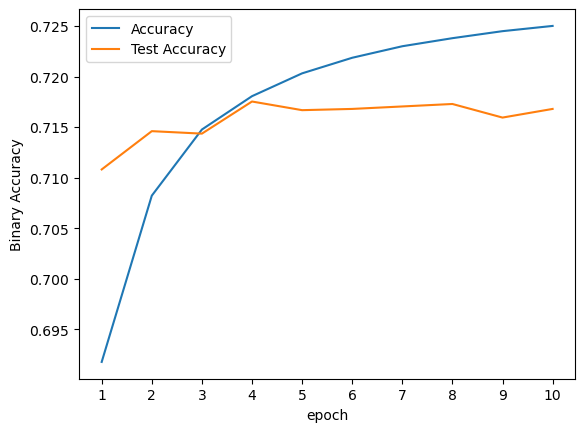

In [195]:
history = model.history

acc = [_[0] for _ in history]
test_acc = [_[1] for _ in history]

plt.plot(range(1, 11),acc, label="Accuracy")
plt.plot(range(1, 11),test_acc, label="Test Accuracy")
plt.xticks(range(1, 11))
plt.xlabel("epoch")
plt.ylabel("Binary Accuracy")
plt.legend()
plt.show()

In [175]:
# Precision Recall
y = [_[1].numpy() for _ in iter(model.test_data)]
y_preds = [_.numpy() for _ in model.predicts]

y = np.array(y)
y_preds = np.array([_ for _ in y_preds]).round()

In [176]:
from sklearn.metrics import recall_score, precision_score

precision = precision_score(y, y_preds, average='macro')
recall = recall_score(y, y_preds, average='macro')

print("precision : {} - recall : {}".format(precision, recall))

precision : 0.5412323985971867 - recall : 0.5299350400745968
